# 🚀 Detect AI vs. Human-Generated Images  

### **Competition Overview**  
[🔗 **Kaggle Competition Link**](https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images/overview)  

This challenge focuses on distinguishing **AI-generated images** from **human-created** ones—a critical task in today’s digital landscape where deepfakes and synthetic media are rapidly evolving. Participants will develop ML models to classify images accurately while ensuring fairness and robustness.  


## Imports & Device Setup
### Purpose
- Load all the Python libraries needed for data handling, model creation, training loops, and evaluation metrics.  
- Detect whether you have a CUDA GPU, Apple MPS device, or only a CPU, and set `device` so that all tensors and models are moved appropriately.



In [36]:
# Cell 1: Imports & device setup
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import timm
from PIL import Image

# Device‑agnostic setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

# Paths
base_dir = "data/detect-ai-vs-human-generated-images"
csv_path = os.path.join(base_dir, "train.csv")

Using device: mps




## Data Transforms  
### Purpose
- Define two preprocessing pipelines—one for training (with augmentation) and one for validation (deterministic)—so that:
  - **train_transform** introduces variability (random crops, flips, color jitter) to help the model generalize.  
  - **val_transform** only resizes and normalizes, giving a consistent evaluation set.

### Insight
- **RandomResizedCrop** and **RandomHorizontalFlip** simulate different viewpoints and scales, reducing overfitting on background details.  
- **ColorJitter** makes the model robust to lighting changes (important if AI‑generated vs. human images have different color profiles).  
- **Normalize** centers and scales pixel values based on ImageNet statistics—critical because we use **pretrained** models that expect inputs normalized this way.


In [37]:
# Cell 2: Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



## Dataset & DataLoaders  
### Purpose
- **DetectAIDataset**: reads each row of `train.csv`, loads the image file, applies the appropriate transform, and returns `(image_tensor, label)`.  
- Split the dataset into **train** and **validation** subsets (95%/5%) **stratified** by label to keep class balance.  
- Wrap each subset in a PyTorch `DataLoader` for efficient batch fetching, shuffling (train), and parallel I/O (multi‑worker).

### Insight
- **Stratified split** ensures the rare class (if one exists) appears in both train and validation—avoiding misleading accuracy swings.  
- **num_workers > 0** speeds up data loading but required the `fork` workaround on macOS to avoid pickling errors.  
- **pin_memory=True** can slightly boost GPU throughput by keeping batches in page‑locked memory.



In [ ]:
# Cell 3: Dataset class, splits & DataLoaders
class DetectAIDataset(Dataset):
    """
    Loads images and labels from CSV for AI vs human-generated classification.
    """
    def __init__(self, csv_file, base_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row["file_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = int(row["label"])
        return image, label

# Full dataset w/ train transforms
full_dataset = DetectAIDataset(csv_file=csv_path,
                               base_dir=base_dir,
                               transform=train_transform)

# Stratified train/val split
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.05,
    random_state=42,
    stratify=pd.read_csv(csv_path)['label']
)

train_subset = Subset(full_dataset, train_indices)
val_dataset  = DetectAIDataset(csv_file=csv_path,
                               base_dir=base_dir,
                               transform=val_transform)
val_subset   = Subset(val_dataset, val_indices)

batch_size, num_workers = 32, 4
train_loader = DataLoader(train_subset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=num_workers, 
                          pin_memory=True)
val_loader   = DataLoader(val_subset,   
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=num_workers, 
                          pin_memory=True)


## Models Considered  
### ViT  
#### Background  
- **Vision Transformer (ViT)** divides an image into fixed-size patches, flattens them, and processes them with transformer encoder blocks—borrowing the global **self-attention** mechanism from NLP.  
- **Why ViT?**  
  - Often achieves **state-of-the-art** on vision tasks with fewer inductive biases than CNNs—useful when distinguishing subtle “AI-generated” artifacts.  
  - Its patch-based attention can capture long-range dependencies (e.g., unnatural textures spanning the image).  
- **Freezing and Unfreezing**  
  - We **freeze** early transformer blocks and the patch embedding to preserve the powerful pretrained ImageNet representations and reduce trainable parameters.  
  - After a few epochs, we **unfreeze** the last block for **fine-tuning**—allowing the model to adapt high-level features to our two-class problem without catastrophic forgetting.  

### EfficientNet-B3  
#### Background  
- **EfficientNet-B3** is a CNN optimized via **compound scaling** (uniformly increasing depth, width, and resolution) for efficiency and performance.  
- **Why EfficientNet?**  
  - Balances computational cost and accuracy, often outperforming larger models like ResNet50 with fewer parameters.  
  - Its **depthwise separable convolutions** reduce redundancy, making it efficient for detecting subtle artifacts in AI-generated images.  
- **Freezing and Unfreezing**  
  - We **freeze** early blocks (stem and intermediate layers) to retain generic feature extractors (e.g., edge detectors).  
  - Gradually **unfreeze** later blocks (e.g., `blocks_6` to `blocks_8`) to fine-tune task-specific hierarchical features while avoiding overfitting.  

### ResNet50  
#### Background  
- **ResNet50** is a classic residual network with **skip connections**, enabling stable training of very deep architectures by mitigating vanishing gradients.  
- **Why ResNet50?**  
  - Provides a **reliable baseline**—its performance is well-documented across domains, making comparisons interpretable.  
  - Residual blocks excel at preserving gradient flow, which is critical for learning fine-grained artifacts in AI-generated images.  
- **Freezing and Unfreezing**  
  - We **freeze** all layers except the final residual block (`layer4`) and the fully connected head.  
  - This ensures the model retains low-level features (e.g., textures) while adapting high-level representations to the binary classification task.  

### ConvNeXt  
#### Background  
- **ConvNeXt** modernizes CNNs by adopting transformer-inspired designs (e.g., **large kernel sizes**, LayerNorm, and fewer activation layers).  
- **Why ConvNeXt?**  
  - Bridges the gap between CNNs and transformers, offering ViT-like performance with CNN efficiency.  
  - Its **hierarchical feature maps** (like traditional CNNs) may better capture local artifacts (e.g., unnatural pixel clusters) in AI-generated images.  
- **Freezing and Unfreezing**  
  - We **freeze** early stages (`stem` and `downsampling layers`) to leverage pretrained hierarchical representations.  
  - **Unfreeze** later stages (e.g., `stage 3` and `stage 4`) to refine global context understanding for the task.  

### Loading Pretrained & Freezing  
- **Pretrained weights** give you a huge head start—your dataset is relatively small, so training from scratch would overfit or converge slowly.  
- **Freezing** early layers:  
  - Reduces total trainable parameters → speeds up training  
  - Protects general, low-level features (edges, textures) from being wiped out by random gradients on a small dataset  
- **Gradual unfreezing**:  
  - Allows high-level blocks to adapt to the new task while retaining stable low-level feature detectors  
  - Done at a lower learning rate (via scheduler) to avoid large parameter jumps  


In [39]:
# Cell 4: Model‑builder functions
def get_model_vit(num_classes=2, num_freeze_layers=1):
    model = timm.create_model('vit_base_patch16_224',
                              pretrained=True,
                              num_classes=num_classes)
    if hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        for i in range(total_blocks - num_freeze_layers):
            for p in model.blocks[i].parameters():
                p.requires_grad = False
        if hasattr(model, 'patch_embed'):
            for p in model.patch_embed.parameters():
                p.requires_grad = False
    return model

def get_model_efficientnet(num_classes=2, num_freeze_layers=1):
    model = timm.create_model('efficientnet_b3',
                              pretrained=True,
                              num_classes=num_classes)
    if hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        for i in range(total_blocks - num_freeze_layers):
            for p in model.blocks[i].parameters():
                p.requires_grad = False
    return model

def get_model_resnet50(num_classes=2, num_freeze_layers=1):
    model = timm.create_model('resnet50',
                              pretrained=True,
                              num_classes=num_classes)
    if num_freeze_layers >= 1:
        for name, module in model.named_children():
            if name not in ['layer4', 'fc']:
                for p in module.parameters():
                    p.requires_grad = False
    return model

def get_model_convnext(num_classes=2, num_freeze_layers=1):
    model = timm.create_model('convnext_base',
                              pretrained=True,
                              num_classes=num_classes)
    if hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        for i in range(total_blocks - num_freeze_layers):
            for p in model.blocks[i].parameters():
                p.requires_grad = False
    return model



## Training Utilities  
### train_step / eval_step  
- Encapsulate one epoch of forward/backward passes or validation evaluation.  
- Return **average loss** (for convergence tracking) and **accuracy** (basic performance check).

### plot_loss_curves  
- Visualize **train vs. val loss** and **accuracy** over epochs—quickly highlights under/over‑fitting.

### train_model  
- Orchestrates the full training:
  - **Early stopping** on validation loss prevents over‑training.  
  - **Learning‑rate scheduler** (StepLR) halves the LR every few epochs, helping refine weights.  
  - **Scheduled unfreezing** of transformer blocks at epoch 3 to unlock additional capacity.
- **Why this setup?**  
  - Balances stability (frozen pretrained layers) with adaptability (fine‑tuning later)  
  - Keeps training efficient and guards against overfitting on a small dataset



In [40]:
# Cell 5: Training utilities
from tqdm.auto import tqdm

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = total_correct = total_samples = 0
    for X, y in tqdm(dataloader, desc="Training", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y).sum().item()
        total_loss   += loss.item() * X.size(0)
        total_samples+= X.size(0)
    return total_loss/total_samples, total_correct/total_samples

def eval_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = total_correct = total_samples = 0
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Validation", leave=False):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y).sum().item()
            total_loss   += loss.item() * X.size(0)
            total_samples+= X.size(0)
    return total_loss/total_samples, total_correct/total_samples

def plot_loss_curves(results):
    epochs = range(len(results["train_loss"]))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, results["train_loss"], label="train_loss")
    plt.plot(epochs, results["val_loss"],   label="val_loss")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, results["train_acc"],  label="train_acc")
    plt.plot(epochs, results["val_acc"],    label="val_acc")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()
    plt.show()

def train_model(model, train_loader, val_loader, loss_fn,
                optimizer, scheduler, epochs, device,
                base_lr, patience=3, unfreeze_epoch=3,
                unfreeze_option="last"):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_loss = float("inf")
    no_improve = 0
    for epoch in range(1, epochs+1):
        t_loss, t_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        v_loss, v_acc = eval_step(model, val_loader, loss_fn, device)
        history["train_loss"].append(t_loss)
        history["train_acc"].append(t_acc)
        history["val_loss"].append(v_loss)
        history["val_acc"].append(v_acc)
        print(f"Epoch {epoch}: train_loss={t_loss:.4f}, train_acc={t_acc:.4f} | val_loss={v_loss:.4f}, val_acc={v_acc:.4f}")
        if v_loss < best_val_loss:
            best_val_loss, no_improve = v_loss, 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        if epoch == unfreeze_epoch and hasattr(model, "blocks"):
            if unfreeze_option == "last":
                print("Unfreezing last block…")
                for p in model.blocks[-1].parameters():
                    p.requires_grad = True
            for g in optimizer.param_groups:
                g["lr"] = base_lr * 0.5
        if scheduler:
            scheduler.step()
    return history



## Instantiate, Train & Plot  
### Purpose
- Build the chosen model (e.g. ViT), move it to `device`, and set up:
  - **loss_fn** = CrossEntropyLoss (standard for multi‑class/binary tasks)  
  - **optimizer** = Adam on only `requires_grad=True` parameters (faster convergence)  
  - **scheduler** = StepLR to reduce LR mid‑training  
- Run `train_model` for a fixed number of epochs, then call `plot_loss_curves`.

### Insight
- Starting with a **low LR (1e‑4)** helps fine‑tuning avoid large parameter shifts.  
- A **few epochs** (e.g., 5) plus early stopping is usually enough when fine‑tuning a pretrained model.



Training:   0%|          | 0/1187 [00:00<?, ?it/s]

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


Epoch 1: train_loss=0.1765, train_acc=0.9265 | val_loss=0.1148, val_acc=0.9582


Training:   0%|          | 0/1187 [00:00<?, ?it/s]

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded
Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Prev

Epoch 2: train_loss=0.0874, train_acc=0.9658 | val_loss=0.0980, val_acc=0.9665
Unfreezing last block…


Training:   0%|          | 0/1187 [00:00<?, ?it/s]

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


Epoch 3: train_loss=0.0491, train_acc=0.9811 | val_loss=0.0807, val_acc=0.9715


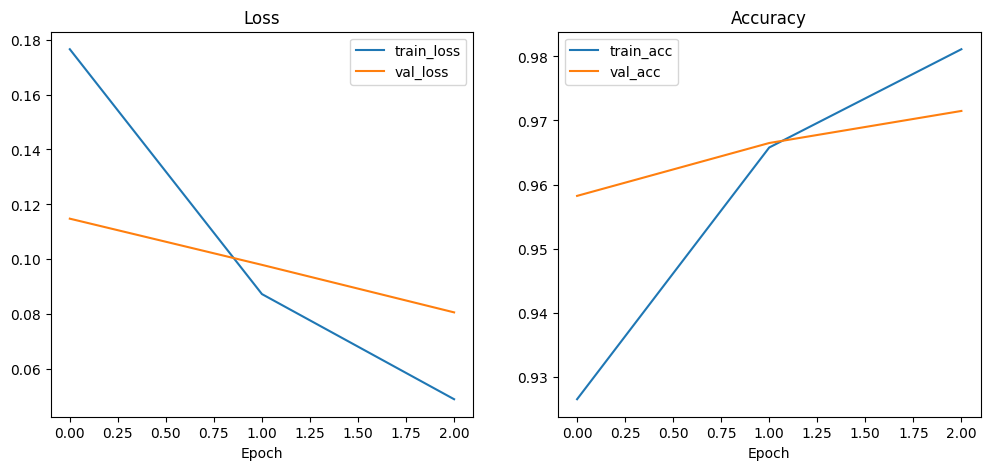

In [41]:
# Cell 6: Instantiate, train & plot
vit_model = get_model_vit(num_classes=2, num_freeze_layers=1).to(device)

loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vit_model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_model(
    model=vit_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=3,
    device=device,
    base_lr=1e-4,
    patience=2,
    unfreeze_epoch=2,
    unfreeze_option="last"
)

plot_loss_curves(history)


## Compute Metrics on Validation Set  
### Definitions
- **Accuracy** = (TP + TN) / (TP + TN + FP + FN)  
  - Measures the overall correctness of the model: the proportion of correctly classified images (both AI and human) out of all predictions.  

- **Precision** = TP / (TP + FP)  
  - Measures how reliable the model is when it predicts an image as "AI-generated."  
  - Example: If the model labels 100 images as AI-generated, and 80 truly are, the precision is 80%.  

- **Recall (Sensitivity)** = TP / (TP + FN)  
  - Measures how well the model captures AI-generated images without missing them.  
  - Example: If there are 100 true AI-generated images, and the model detects 70, the recall is 70%.  

- **F1-score** = 2·(Precision·Recall) / (Precision + Recall)  
  - A balanced metric combining precision and recall, useful when class imbalance exists.  
  - Example: If precision is 80% and recall is 70%, the F1-score is ~74.4%.  


### Why F1 for this competition?  
- **Class imbalance** occurs when one category (e.g., "AI-generated images") is significantly rarer than another (e.g., "human-generated images"). For example:  
  - If only 10% of the dataset is AI-generated and 90% is human, a naive model that *always* predicts "human" would achieve 90% accuracy—while failing entirely on the AI class.  
  - Metrics like accuracy become misleading because they favor the majority class.  

- **F1-score mitigates this issue** by:  
  - Ignoring true negatives (TN) in its calculation, focusing instead on the model’s ability to:  
    1. Correctly identify the rare class (AI images, via **recall**).  
    2. Avoid mislabeling human images as AI (via **precision**).  
  - Penalizing models that over-predict the majority class (e.g., always guessing "human").  

- **Example**:  
  - In a dataset with 95% human images, a model with 95% accuracy could be useless if it never detects AI images.  
  - F1-score would expose this failure by dropping to ~0% if recall (AI detection) is 0%.  



In [42]:

# Cell 7: Compute precision, recall, F1 on validation
from sklearn.metrics import precision_score, recall_score, f1_score

vit_model.eval()
all_preds, all_labels = [], []

with torch.inference_mode():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        logits = vit_model(X)
        probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds  = (probs >= 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Exception ignored in: <function _silent_iter_del at 0x35bba91c0>
Traceback (most recent call last):
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  File "/var/folders/d_/bbmbtkjx5bldzz_9b7565vyh0000gn/T/ipykernel_48716/4246819289.py", line 8, in _silent_iter_del
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


Precision: 0.9659, Recall: 0.9775, F1: 0.9717




## Generate `submission.csv`  
### Purpose
- Read `test.csv` (only image IDs).  
- For each image:
  - Load and apply `val_transform`  
  - Run inference, compute `prob = softmax(...)[1]`  
  - Threshold `prob ≥ 0.5` → label 1 (AI) or 0 (human)  
- Save two‑column CSV (`id`, `label`) for direct submission.

### Insight
- Using **the same validation transforms** ensures consistency between how images are seen at test time and validation time.  
- A **0.5 threshold** is natural for a balanced binary classification, aligning with the F1‑score calculation at the 0.5 cutoff.

In [43]:
# Cell 8: Generate submission.csv
test_csv_path = os.path.join(base_dir, "test.csv")
df_test = pd.read_csv(test_csv_path)  # expects an 'id' column

test_labels = []
vit_model.eval()
with torch.inference_mode():
    for _, row in df_test.iterrows():
        img   = Image.open(os.path.join(base_dir, row["id"])).convert("RGB")
        img_t = val_transform(img).unsqueeze(0).to(device)
        prob  = torch.softmax(vit_model(img_t), dim=1)[0,1].item()
        test_labels.append(int(prob >= 0.5))

df_test["label"] = test_labels
df_test[["id","label"]].to_csv("submission.csv", index=False)
print("Saved submission.csv")

Saved submission.csv
